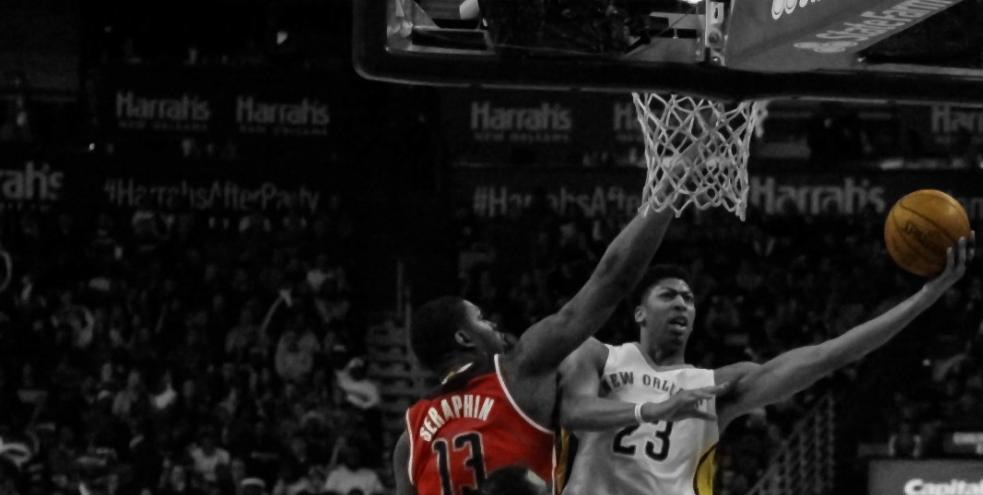

# Disclaimer! This kernel is only for educational purposes and made for fun therefor the content of the kernel should not be taken to seriously!

All the data preprocessing is based on [This Kernel.](https://www.kaggle.com/ratan123/march-madness-2020-ncaam-simple-lightgbm-on-kfold)
Thank you for that!!
The main purpose of this kernel is to build a simple ML model. 


In [ ]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

#grafs
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# Import Dependencies
%matplotlib inline

# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv
import lightgbm as lgb
# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')



# Importing data

In [ ]:
tourney_result = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MNCAATourneyCompactResults.csv')
tourney_seed = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MNCAATourneySeeds.csv')

# tourney_result cleaning

In [ ]:
tourney_result = tourney_result.drop(['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], axis=1)
tourney_result
tourney_result = pd.merge(tourney_result, tourney_seed, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Seed':'WSeed'}, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)
tourney_result = pd.merge(tourney_result, tourney_seed, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Seed':'LSeed'}, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)
tourney_result

In [ ]:
# Get String
def get_seed(x):
    return int(x[1:3])

tourney_result['WSeed'] = tourney_result['WSeed'].map(lambda x: get_seed(x))
tourney_result['LSeed'] = tourney_result['LSeed'].map(lambda x: get_seed(x))
tourney_result

In [ ]:
season_result = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MRegularSeasonCompactResults.csv')

In [ ]:
season_win_result = season_result[['Season', 'WTeamID', 'WScore']]
season_lose_result = season_result[['Season', 'LTeamID', 'LScore']]
season_win_result.rename(columns={'WTeamID':'TeamID', 'WScore':'Score'}, inplace=True)
season_lose_result.rename(columns={'LTeamID':'TeamID', 'LScore':'Score'}, inplace=True)
season_result = pd.concat((season_win_result, season_lose_result)).reset_index(drop=True)
season_result

In [ ]:
season_score = season_result.groupby(['Season', 'TeamID'])['Score'].sum().reset_index()
season_score

In [ ]:
tourney_result = pd.merge(tourney_result, season_score, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Score':'WScoreT'}, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)
tourney_result = pd.merge(tourney_result, season_score, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
tourney_result.rename(columns={'Score':'LScoreT'}, inplace=True)
tourney_result = tourney_result.drop('TeamID', axis=1)
tourney_result
#WScoreT is Score in this year

In [ ]:
tourney_win_result = tourney_result.drop(['Season', 'WTeamID', 'LTeamID'], axis=1)
tourney_win_result.rename(columns={'WSeed':'Seed1', 'LSeed':'Seed2', 'WScoreT':'ScoreT1', 'LScoreT':'ScoreT2'}, inplace=True)
tourney_win_result

In [ ]:
tourney_lose_result = tourney_win_result.copy()
tourney_lose_result['Seed1'] = tourney_win_result['Seed2']
tourney_lose_result['Seed2'] = tourney_win_result['Seed1']
tourney_lose_result['ScoreT1'] = tourney_win_result['ScoreT2']
tourney_lose_result['ScoreT2'] = tourney_win_result['ScoreT1']
tourney_lose_result

In [ ]:
tourney_win_result['Seed_diff'] = tourney_win_result['Seed1'] - tourney_win_result['Seed2']
tourney_win_result['ScoreT_diff'] = tourney_win_result['ScoreT1'] - tourney_win_result['ScoreT2']
tourney_lose_result['Seed_diff'] = tourney_lose_result['Seed1'] - tourney_lose_result['Seed2']
tourney_lose_result['ScoreT_diff'] = tourney_lose_result['ScoreT1'] - tourney_lose_result['ScoreT2']

In [ ]:
tourney_win_result['result'] = 1
tourney_lose_result['result'] = 0
tourney_result = pd.concat((tourney_win_result, tourney_lose_result)).reset_index(drop=True)
tourney_result

# test data cleaning

In [ ]:
test_df = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MSampleSubmissionStage1_2020.csv')
test_df['Season'] = test_df['ID'].map(lambda x: int(x[:4]))
test_df['WTeamID'] = test_df['ID'].map(lambda x: int(x[5:9]))
test_df['LTeamID'] = test_df['ID'].map(lambda x: int(x[10:14]))
test_df


In [ ]:
test_df = pd.merge(test_df, tourney_seed, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
test_df.rename(columns={'Seed':'Seed1'}, inplace=True)
test_df = test_df.drop('TeamID', axis=1)
test_df = pd.merge(test_df, tourney_seed, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
test_df.rename(columns={'Seed':'Seed2'}, inplace=True)
test_df = test_df.drop('TeamID', axis=1)
test_df = pd.merge(test_df, season_score, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
test_df.rename(columns={'Score':'ScoreT1'}, inplace=True)
test_df = test_df.drop('TeamID', axis=1)
test_df = pd.merge(test_df, season_score, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
test_df.rename(columns={'Score':'ScoreT2'}, inplace=True)
test_df = test_df.drop('TeamID', axis=1)
test_df

In [ ]:
test_df['Seed1'] = test_df['Seed1'].map(lambda x: get_seed(x))
test_df['Seed2'] = test_df['Seed2'].map(lambda x: get_seed(x))
test_df['Seed_diff'] = test_df['Seed1'] - test_df['Seed2']
test_df['ScoreT_diff'] = test_df['ScoreT1'] - test_df['ScoreT2']
test_df = test_df.drop(['ID', 'Pred', 'Season', 'WTeamID', 'LTeamID'], axis=1)
test_df

# model prep

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
X = tourney_result.copy()
X_test_full = test_df.copy()

# Remove rows with missing target, separate target from predictors
X.dropna(axis=0, subset=['result'], inplace=True)
y = X.result              
X.drop(['result'], axis=1, inplace=True)
   
    
    # Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]
# Low cardinality means that the column contains a lot of “repeats” in its data range.
# Examples of categorical variables are race, sex, age group, and educational level. 
# While the latter two variables may also be considered in a numerical manner by using exact values for age 
# and highest grade completed
# nunique() function to find the number of unique values over the column axis. So when it finds over 10 uniqe 
# values and the cname is a 
# dtype 'object' which means Data type objects are useful for creating structured arrays. 
# A structured array is the one which contains different types of data.

### one line meaning of above####
## for cname in a dataframes column shall return a value to 'low_cardinality_cols' if there are more then 10 uniqe values
## and the dtype shall be a object which is a structured array that can have different types of data (lik; int, float string ect.)


# Select numeric columns
numeric_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]
### for cname (every value, one at the time) in dataframe for columns return a value to 'numeric_cols' if the 
### dtype= int64 or float64. 



# Keep selected columns only
my_cols = low_cardinality_cols + numeric_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

# One-hot encode the data (to shorten the code, we use pandas)
X_train = pd.get_dummies(X_train)
X_valid = pd.get_dummies(X_valid)
X_test = pd.get_dummies(X_test)
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)

In [ ]:
X_train.head()

In [ ]:
y.head()

# Model / predictions

In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from xgboost import XGBRegressor


model2 = RandomForestClassifier(n_estimators=150, max_depth=4, random_state=1)
model_0 = GradientBoostingClassifier(random_state=1)
model3 = DecisionTreeClassifier(max_depth=3, random_state=1)
#model=SGDClassifier(random_state=1)
#model=ExtraTreesClassifier(random_state=1)
model = XGBRegressor()
# Define the models
model_1 = RandomForestClassifier(n_estimators=50, random_state=0)
model_2 = RandomForestClassifier(n_estimators=100, random_state=0)
model_3 = RandomForestClassifier(n_estimators=200, min_samples_split=20, random_state=0)
model_4 = RandomForestClassifier(n_estimators=300, max_depth=6, random_state=1)



model.fit(X_train,y_train)


print(f'Model test accuracy: {model.score(X_valid, y_valid)*100:.3f}%')

# more predictions

In [ ]:
model2.fit(X_train,y_train)
print(f'Model test accuracy: {model2.score(X_valid, y_valid)*100:.3f}%')
model3.fit(X_train,y_train)
print(f'Model test accuracy: {model3.score(X_valid, y_valid)*100:.3f}%')

In [ ]:
model_1.fit(X_train,y_train)
print(f'Model test accuracy: {model_1.score(X_valid, y_valid)*100:.3f}%')
model_2.fit(X_train,y_train)
print(f'Model test accuracy: {model_2.score(X_valid, y_valid)*100:.3f}%')
model_3.fit(X_train,y_train)
print(f'Model test accuracy: {model_3.score(X_valid, y_valid)*100:.3f}%')
model_4.fit(X_train,y_train)
print(f'Model test accuracy: {model_4.score(X_valid, y_valid)*100:.3f}%')

# Submission

In [ ]:
Pred = model.predict(X_test)

# to submit
submission_df = pd.read_csv('../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MSampleSubmissionStage1_2020.csv')
submission_df['Pred'] = Pred

output = pd.DataFrame({'ID': submission_df.ID, 'Pred': Pred})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

In [ ]:
if len(output) == len(submission_df):
    print("Submission dataframe is the same length as test ({} rows).".format(len(output)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Thank you for reading my kernal, if there are any mistakes or improvement you want to point out, feel free to do so in the comments, and thank you in advance if you do! 